## Content-based book recommendation system

<p>The aim is to develop the bases of <strong>a content-based book recommendation system</strong>, which will determine which books are close to each other based on how similar the discussed topics are. The methods used are commonly used in text- or documents-heavy industries to perform some common task such as text classification or handling search engine queries.</p>


In [1]:
# Import libraries
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt

from gensim import corpora, similarities
from gensim.models import TfidfModel
from nltk.stem import PorterStemmer
from scipy.cluster import hierarchy
%matplotlib inline

#### Import Data
<p> The training data used here a collection of Charles Darwin's books, the most famous being "On the origin of species".<br>
As a first step, the content of the books is to be loaded into Python and do some basic pre-processing. Such a collection of texts is called <strong>a corpus</strong>. The titles for these books are also stored for future references and print their respective length to get a gauge for their contents.</p>

In [2]:
books = []
titles = []

folder = "datasets"
files = sorted(list(glob.glob(f"{folder}/*.txt")))
for file in files:
    title = file.strip(".txt").split('/')[-1]    # Get the title only from the filepath
    text = open(file, encoding='utf-8-sig').read()
    text = re.sub(r'[^a-zA-Z0-9\s]+', '', text)   # Remove all non-alpha-numeric characters

    books.append(text)
    titles.append(title)
    print(f"{title:40s} : {len(text):5d} words")

Autobiography                            : 123229 words
Coral Reefs                              : 496539 words
Descent of Man                           : 1785723 words
Different Forms of Flowers               : 616671 words
Effects Cross Self Fertilization         : 919542 words
Expression of Emotion Man Animals        : 624250 words
Formation Vegetable Mould                : 342689 words
Foundations Origin of Species            : 534797 words
Geological Observations South America    : 796499 words
Insectivorous Plants                     : 904003 words
Life and Letters Vol1                    : 1047646 words
Life and Letters Vol2                    : 1014384 words
Monograph Cirripedia Vol2                : 1723333 words
Monograph Cirripedia                     : 777741 words
Movement Climbing Plants                 : 305219 words
Origin of Species                        : 919177 words
Power Movement Plants                    : 1094855 words
Variation Plants Animals Domestication   : 

In [3]:
# Storing the index of "On the origin of Species" in a variable for future reference
index = titles.index("Origin of Species")
print(index)

15


#### Tokenize the corpus
<p>As a next step, the corpus needs to be transformed into a format that is easier to deal with for the downstream analyses: tokenise the corpus, i.e., transform each text into a list of the individual words (called tokens) it is made of. To check the output of our process, the first 10 tokens of "<em>On the Origin of Species</em>" are printed.</p>

In [4]:
# Define a list of stop words
stoplist = set('for a of the and to in to be which some is at that we i who whom show via may my our might as well'.split())
books_split = [b.lower().split() for b in books] # Transform the text into tokens
books_tokens = [[t for t in book if t not in stoplist] for book in books_split] # Remove tokens which are part of the list of stop words

print("First 10 tokens of Origin of Species :",books_tokens[index][:10])

First 10 tokens of Origin of Species : ['on', 'origin', 'species', 'but', 'with', 'regard', 'material', 'world', 'can', 'least']


####  Stemming tokenized corpus
<p>Different words can be used to refer a similar concept. For example, the concept of selection can be described by words such as <em>selection</em>, <em>selective</em>, <em>select</em> or <em>selects</em>. This will dilute the weight given to this concept in the book and potentially bias the results of the analysis.</p>
<p>To solve this issue, it is a common practice to use a <strong>stemming process</strong>, which will group together the inflected forms of a word so they can be analysed as a single item: <strong>the stem</strong>, select in the example above, dropping all the other suffixes. The Porter Algorithm is used here as it is more efficient and widely used for stemming English literature. 

In [5]:
stemmer = PorterStemmer()
books_stem = [[stemmer.stem(word) for word in book] for book in books_tokens]

print("First 10 stems in Origin of Species :",books_stem[index][:10])

First 10 stems in Origin of Species : ['on', 'origin', 'speci', 'but', 'with', 'regard', 'materi', 'world', 'can', 'least']


#### Bag-of-words model
<p>Now that the texts are transformed into stemmed tokens, models that will be useable by downstream algorithms are to be build. For this, a universe of all words contained in our corpus of Charles Darwin's books is created, which is called <em>a dictionary</em>. Then, using the stemmed tokens and the dictionary, a <strong>bag-of-words models</strong> (BoW) of each of the books is created. The BoW models will represent the books as a list of all uniques tokens they contain associated with their respective number of occurrences. </p>

In [6]:
dictionary = corpora.Dictionary(books_stem) # Create a dictionary from all the stemmed tokens to generate token ids
bows = [dictionary.doc2bow(book_stem, allow_update=True) for book_stem in books_stem] # Create a bag-of-words model for each book

print(bows[index][:10])

[(0, 3), (5, 4), (6, 1), (8, 2), (22, 1), (24, 2), (28, 1), (29, 3), (36, 1), (37, 1)]


<p>It is not straightforward to understand which stemmed tokens are present in a given book from Charles Darwin from the above output. In order to better understand how the model has been generated and visualize its content, the bag of words is transformed to a DataFrame and display the 10 most common stems for the book "<em>On the Origin of Species</em>".</p>

In [7]:
df = pd.DataFrame(bows[index])
df.columns = ["Id", "Count"]
df["Token"] = df["Id"].apply(lambda t:dictionary[t]) # Add a column containing the token corresponding to the dictionary index
df = df.sort_values(by=["Count"], ascending=False)

print(df.head(10))

        Id  Count  Token
730   1194   2022   have
1090  1778   1520     on
870   1394   1468     it
1461  2340   1465  speci
231    401   1357     by
1099  1789   1200     or
120    220   1136    are
652   1067   1135   from
1743  2761    998   with
1578  2503    957    thi


#### tf-idf model
<p>The presence of the stem "<em>speci</em>" is pretty evident as it is from the <em>On the Origin of Species</em> book. The most recurring words are, apart from few exceptions, very common and unlikely to carry any information peculiar to the given book. An additional step needs to be taken in order to determine which tokens are the most specific to a book.</p>
<p>To do so, a <strong>tf-idf model (term frequency–inverse document frequency)</strong> is used. This model defines the importance of each word depending on how frequent it is in this text and how infrequent it is in all the other documents. As a result, a high tf-idf score for a word will indicate that this word is specific to this text.</p>

In [8]:
model = TfidfModel(bows)

print(model[bows[index][:10]])

[(8, 0.058702006284437135), (22, 0.16461717878159088), (24, 0.49300443166358754), (28, 0.09299643681137687), (29, 0.7395066474953813), (36, 0.2923041825896135), (37, 0.2923041825896135)]


<p>Once again, the format of those results is hard to interpret for a human. Therefore, it is transformed into a more readable version and display the 10 most specific words for the "<em>On the Origin of Species</em>" book.</p>

In [9]:
df_tfidf = pd.DataFrame(model[bows[index]])
df_tfidf.columns = ["Id", "Score"]
df_tfidf["Token"] = df_tfidf["Id"].apply(lambda t:dictionary[t])
df_tfidf = df_tfidf.sort_values(by=["Score"], ascending=False)

df_tfidf.head(10)

,Id,Score,Token
863,2214,0.306752,select
122,376,0.209155,breed
3040,10860,0.156172,migrat
3164,11698,0.150137,pigeon
932,2377,0.142106,steril
276,765,0.138353,domest
3980,21051,0.122648,grtner
364,985,0.119839,fertil
491,1282,0.118089,hybrid
423,1116,0.117231,glacial


#### Distance between texts
<p>The results of the tf-idf algorithm now return stemmed tokens which are specific to each book. For example, it can be seen that topics such as selection, breeding or domestication are defining "<em>On the Origin of Species</em>". Now that there is a model associating tokens to how specific they are to each book, how related to books are between each other can be measured.</p>
<p>To this purpose, a measure of similarity called <strong>cosine similarity</strong> is used and the results can be visualised as a distance matrix, i.e., a matrix showing all pairwise distances between Darwin's books.</p>

In [10]:
sims = similarities.MatrixSimilarity(bows) # Compute the similarity matrix (pairwise distance between all texts)

sim_df = pd.DataFrame(sims)
sim_df.columns = titles
sim_df.index = titles

#### The book most similar to "On the Origin of Species"
<p>There is a matrix containing all the similarity measures between any pair of books from Charles Darwin! This matrix can be used to quickly extract the information needed, i.e., the distance between one book and one or several others. </p>
<p>As a first step, the books the most similar to "<em>On the Origin of Species</em>,"are displayed,  more specifically, a bar chart showing all books ranked by how similar they are to Darwin's landmark work.</p>

Text(0.5, 1.0, 'Similarity with Origin of Species')

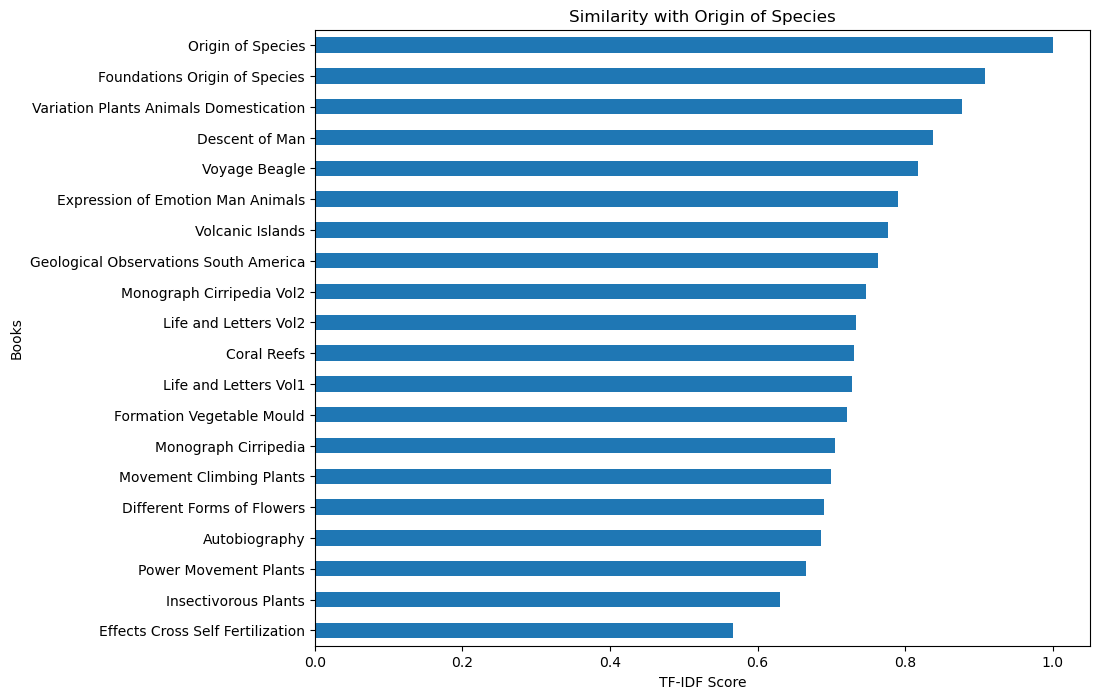

In [11]:
v = sim_df["Origin of Species"] # Select the column corresponding to "On the Origin of Species"
v_sorted = v.sort_values() # Sort by ascending scores

plt.figure(figsize=(10,8))
v_sorted.plot.barh();
plt.xlabel("TF-IDF Score")
plt.ylabel("Books")
plt.title("Similarity with Origin of Species")

#### Inferences
<p>This turns out to be extremely useful if a given book's most similar work needs to be determined. For example, if you enjoyed "<em>On the Origin of Species</em>," you can read books discussing similar concepts such as "<em>The Variation of Animals and Plants under Domestication</em>" or "<em>The Descent of Man, and Selection in Relation to Sex</em>." If you are familiar with Darwin's work, these suggestions will likely seem natural to you. Indeed, <em>On the Origin of Species</em> has a whole chapter about domestication and <em>The Descent of Man, and Selection in Relation to Sex</em> applies the theory of natural selection to human evolution. Hence, the results make sense.</p>
<p>However, to understand the big picture and see how Darwin's books are generally related to each other (in terms of topics discussed), the whole similarity matrix is represented as a heatmap and a dendrogram, which is a standard tool to display such data. <strong>This last approach will display all the information about book similarities at once.</strong> A book's closest relative can be seen. Also, it can be visualised that which groups of books have similar topics (e.g., the cluster about Charles Darwin personal life with his autobiography and letters). If you are familiar with Darwin's bibliography, the results should not surprise you too much, which indicates the method gives good results. Otherwise, next time you read one of the author's book, you will know which other books to read next in order to learn more about the topics it addressed.</p>

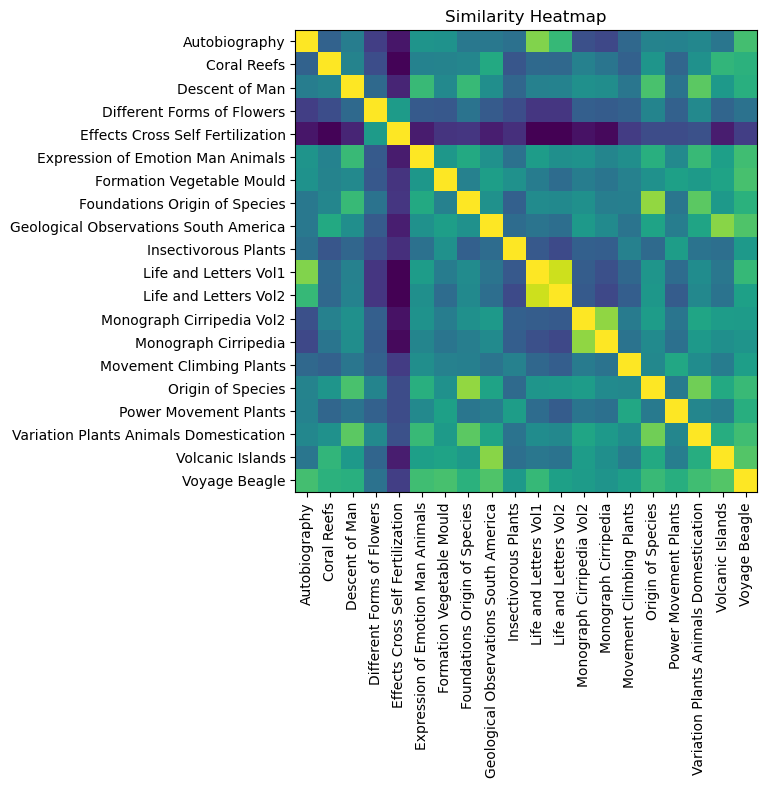

In [12]:
# Heatmap
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
plt.imshow(sim_df)
ax.set_xticks(range(len(titles)))
ax.set_xticklabels(titles, rotation=90)
ax.set_yticks(range(len(titles)))
ax.set_yticklabels(titles)
plt.title("Similarity Heatmap")
plt.show()

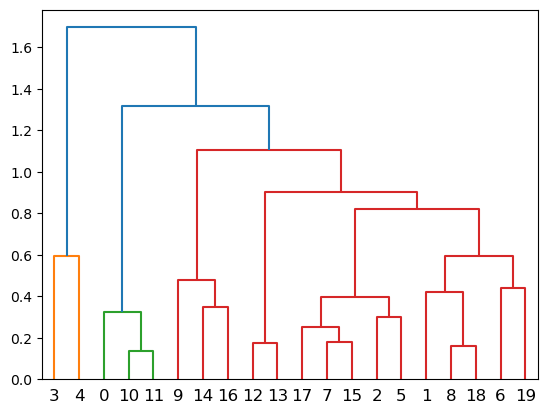

In [13]:
# Compute the clusters from the similarity matrix using Ward variance minimization algorithm
Z = hierarchy.linkage(sims, method="ward");
hierarchy.dendrogram(Z);

#### Conclusion
The developed model examines book contents, computes similarities, and suggests recommendations based on the topics discussed. This capability can be expanded to propose YouTube videos or Instagram reels by considering the described hashtags. After assessing similarities using the hashtags, the model selects related items for recommendations.